# Imports

In [1]:
# !python -m spacy download nl_core_news_sm
# !python -m spacy download nl_core_news_md
# !python -m spacy download nl_core_news_lg

!pip install spacy
# !pip install spacy[transformers]
# !pip install spacy-lookups-data

  Using cached numpy-2.2.4-cp310-cp310-win_amd64.whl.metadata (60 kB)
   ---------------------------------------- 0.0/12.2 MB ? eta -:--:--
    --------------------------------------- 0.3/12.2 MB ? eta -:--:--
   - -------------------------------------- 0.5/12.2 MB 1.2 MB/s eta 0:00:10
   -- ------------------------------------- 0.8/12.2 MB 1.1 MB/s eta 0:00:11
   --- ------------------------------------ 1.0/12.2 MB 1.2 MB/s eta 0:00:10
   ---- ----------------------------------- 1.3/12.2 MB 1.2 MB/s eta 0:00:10
   ----- ---------------------------------- 1.6/12.2 MB 1.2 MB/s eta 0:00:09
   ------ --------------------------------- 1.8/12.2 MB 1.2 MB/s eta 0:00:09
   ------ --------------------------------- 2.1/12.2 MB 1.2 MB/s eta 0:00:09
   ------- -------------------------------- 2.4/12.2 MB 1.2 MB/s eta 0:00:09
   -------- ------------------------------- 2.6/12.2 MB 1.2 MB/s eta 0:00:09
   -------- ------------------------------- 2.6/12.2 MB 1.2 MB/s eta 0:00:09
   --------- -------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scikit-learn 1.3.1 requires numpy<2.0,>=1.17.3, but you have numpy 2.2.4 which is incompatible.
tensorflow-intel 2.13.1 requires numpy<=1.24.3,>=1.22, but you have numpy 2.2.4 which is incompatible.
tensorflow-intel 2.13.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.12.2 which is incompatible.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.4 which is incompatible.
numba 0.61.0 requires numpy<2.2,>=1.24, but you have numpy 2.2.4 which is incompatible.


In [2]:
# to switch Spacy versions:

# !pip install spacy==2.3.9
# !pip install spacy==3.8.2

import spacy
print(f"Spacy version: {spacy.__version__}")

Spacy version: 3.8.2


In [3]:
# In case an uninstall is required:

# !pip uninstall -y spacy
# !python -m spacy.cli.remove-cache

In [55]:
import numpy as np
import matplotlib.pyplot as plt
import spacy
import os
import random
import spacy.training.loop
from spacy import displacy
from spacy.scorer import Scorer
from spacy.tokens import DocBin, Doc
from spacy.training import Example
from spacy.training.loop import train
from spacy.training.example import Example
from spacy.training.initialize import init_nlp
from spacy.util import minibatch
from spacy.util import registry, minibatch
from pathlib import Path
from collections import Counter

In [2]:
import thinc
print(thinc.__version__)

8.3.2


# Visualize Spans

In [23]:
# Load the language model and the data
nlp = spacy.load("nl_core_news_lg")
doc_bin = DocBin().from_disk("training_spans_lg.spacy")
docs = list(doc_bin.get_docs(nlp.vocab))

In [24]:
colors = {
    "Vastgoed": "#8bc34a",  # Green
    "Ondernemingen": "#2196f3",  # Blue
    "Arbeid": "#ffeb3b",  # Yellow
    "Aansprakelijkheid & Letselschade": "#f44336",  # Red
}

In [25]:
options = {
    "spans_key": "sc",  # Adjust if your span key is different
    "colors": colors
}

displacy.render(docs[0], style="span", options=options, jupyter=True)

In [26]:
for i, doc in enumerate(docs[:5]):
    print(f"\nDoc {i+1}:")
    displacy.render(doc, style="span", options=options, jupyter=True)


Doc 1:



Doc 2:



Doc 3:



Doc 4:



Doc 5:


# Plotting Span Length Frequency

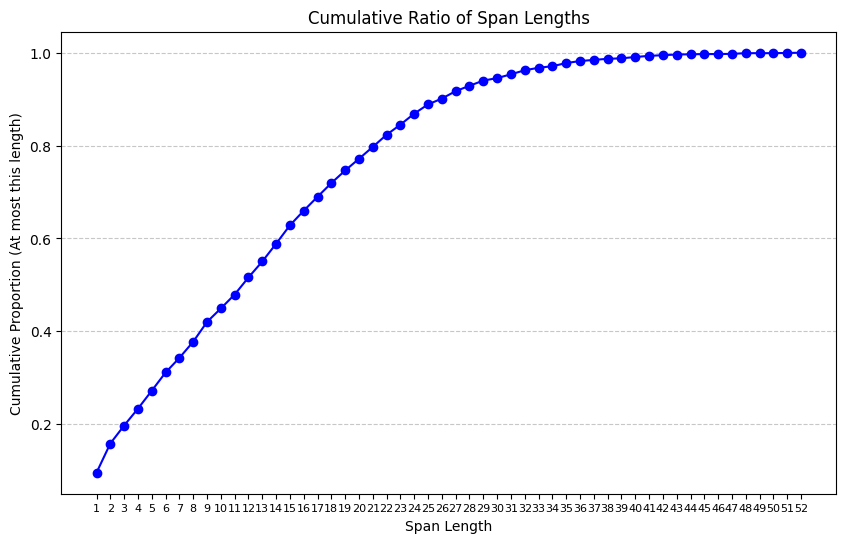

In [27]:
#Obtain the frequency per span length
span_lengths = []
for doc in docs:
    for span in doc.spans.get("sc", []):
        span_lengths.append(len(span))
span_length_counts = np.bincount(span_lengths, minlength=max(span_lengths) + 1)

# Calculate the cumulative sum
cumulative_counts = np.cumsum(span_length_counts)

# Convert to ratio
total_spans = len(span_lengths)
cumulative_ratio = cumulative_counts / total_spans

# Plot cumulative ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_ratio)), cumulative_ratio[1:], marker='o', linestyle='-', color='b')
plt.xlabel('Span Length')
plt.ylabel('Cumulative Proportion (At most this length)')
plt.title('Cumulative Ratio of Span Lengths')
plt.xticks(range(1, max(span_lengths) + 1), fontsize=8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [28]:
# Find the lowest span length where the cumulative ratio is at least 0.9
threshold = 0.9
for span_length, ratio in enumerate(cumulative_ratio[1:], start=1):  # Start at 1 since we skip the first entry (span length 0)
    if ratio >= threshold:
        print(f"Lowest span length with cumulative ratio >= {threshold}: {span_length}")
        break

Lowest span length with cumulative ratio >= 0.9: 26


In [29]:
# Find the lowest span length where the cumulative ratio is at least 0.9
threshold = 0.75
for span_length, ratio in enumerate(cumulative_ratio[1:], start=1):  # Start at 1 since we skip the first entry (span length 0)
    if ratio >= threshold:
        print(f"Lowest span length with cumulative ratio >= {threshold}: {span_length}")
        break

Lowest span length with cumulative ratio >= 0.75: 20


# Tuning SpanCat Models per Label

We tune 4 seperate models, one for each label. This is done such that, in the next phase of the project, training data can be added for specific labels when domain experts only provide feedback for one label instead of all. <br>

We keep 15\% of the data for testing purpuses. <br>

We would like to tune the following hyperparameters: <br>

- best decision threshold. We test for 0.05, 0.10 and 0.15
- Number of epochs to avoid overfitting. We test for 10, 25 and 40 epochs
- n value (for ngrams), We test for 20 and 26 (including and excluding 1)
- nl_core_news_lg vs nl_core_news_md (afterwards)

We do this by calculating performance on validation set (called development set in NLP) and selecting the best one

First of all, let us define 3 functions, one for displaying the span scores, one for calculating the peformance metric given a model and one for tuning the model.

In [17]:
def display_span_scores(nlp, text, spans_key="sc"):
    """..."""
    doc = nlp.make_doc(text)
    spancat = nlp.get_pipe("spancat")
    predictions = spancat.predict([doc])
    spancat.set_annotations([doc], predictions)
    
    labels = spancat.labels
    pred_spans = predictions[0].data.tolist()
    pred_scores = predictions[1].data.tolist()
    
    for (start, end), span_scores in zip(pred_spans, pred_scores):
        span_text = doc[start:end].text
        for label, score in zip(labels, span_scores):
            print(f"Span: '{span_text}', Label: {label}, Score: {score:.3f}")

In [18]:
def evaluate_spancat(nlp, examples, threshold=0.05, spans_key="sc"):
    """..."""
    spancat = nlp.get_pipe("spancat")
    labels = spancat.labels
    
    total_tp, total_fp, total_fn = 0, 0, 0
    overlap_scores = []
    
    for ex in examples:
        doc = ex.predicted
        gold_doc = ex.reference

        # Predict spans for the doc
        predictions = spancat.predict([doc])
        pred_spans = predictions[0].data.tolist()
        pred_scores = predictions[1].data.tolist()

        pred_spans_with_labels = []
        for (start, end), scores in zip(pred_spans, pred_scores):
            for label, score in zip(labels, scores):
                if score >= threshold:
                    pred_spans_with_labels.append((start, end, label))

        # Gold spans
        gold_spans_with_labels = [(span.start, span.end, span.label_) for span in gold_doc.spans.get(spans_key, [])]

        # F1 components
        tp = 0
        matched_golds = set()

        for ps in pred_spans_with_labels:
            if ps in gold_spans_with_labels:
                tp += 1
                matched_golds.add(ps)
        
        fp = len(pred_spans_with_labels) - tp
        fn = len(gold_spans_with_labels) - tp

        total_tp += tp
        total_fp += fp
        total_fn += fn

        # Overlap score per predicted span
        for ps in pred_spans_with_labels:
            best_overlap = 0
            for gs in gold_spans_with_labels:
                if ps[2] != gs[2]:  # labels don't match
                    continue
                pred_start, pred_end = ps[0], ps[1]
                gold_start, gold_end = gs[0], gs[1]
                overlap = max(0, min(pred_end, gold_end) - max(pred_start, gold_start))
                union = max(pred_end, gold_end) - min(pred_start, gold_start)
                overlap_ratio = overlap / union if union > 0 else 0
                if overlap_ratio > best_overlap:
                    best_overlap = overlap_ratio
            overlap_scores.append(best_overlap)

    # Precision, Recall, F1
    precision = total_tp / (total_tp + total_fp) if (total_tp + total_fp) > 0 else 0.0
    recall = total_tp / (total_tp + total_fn) if (total_tp + total_fn) > 0 else 0.0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    # Average overlap score
    avg_overlap_score = sum(overlap_scores) / len(overlap_scores) if overlap_scores else 0.0

    return {"precision": precision, "recall": recall, "f1": f1, "avg_overlap_score": avg_overlap_score}

In [47]:
def tune_spancat_model(language_model: str = "nl_core_news_lg", 
                       tuning_class: str = "Vastgoed", 
                       thresholds: list = [0.05, 0.10, 0.15],
                       epoch_values: list = [10, 25, 40],
                       ngram_sizes: list = [(1, 21), (2, 21), (1, 27), (2, 27)]):

    # Check if tuning_class is valid and if the training data is present
    if not tuning_class in ["Vastgoed", "Ondernemingen", "Arbeid", "Aansprakelijkheid & Letselschade"]:
        raise ValueError('Invalid input data. Please ensure tuning_class ∈ ["Vastgoed", "Ondernemingen", "Arbeid", "Aansprakelijkheid & Letselschade"]')

    print("Beginning to tune model, this may take some time \n\n")
    best_val_score = -1 # Any valid validation score is higher than -1, so this value is always replaced after the first iteration of the nested for loop below.
    best_model = None

    lang_model = spacy.load(language_model)
    doc_bin = DocBin().from_disk(f"Spancat_training_data_lg\\{tuning_class}.spacy")
    docs = list(doc_bin.get_docs(lang_model.vocab))

    # Create Example objects directly from the docs
    train_data = [Example(d, d) for d in docs]
    
    # Shuffle all examples
    random.seed(3479220)
    random.shuffle(train_data)
    
    # Calculate split points
    total = len(train_data)
    train_split = int(total * 0.7)
    dev_split = int(total * 0.85)
    
    # Split data
    train_examples = train_data[:train_split]
    dev_examples = train_data[train_split:dev_split]
    test_examples = train_data[dev_split:]
    
    #Initialize the tuning loop
    for threshold in thresholds:
        for epoch_value in epoch_values:
            for ngram_size in ngram_sizes:

                print(f"Tuning for threshold = {threshold}, ngram_size = {ngram_size} with {epoch_value} epochs. \n")

                # Reset the model by taking the unused language model and Add the spancat component
                nlp = spacy.load(language_model)
                spancat = nlp.add_pipe("spancat", config={
                    "spans_key": "sc",
                    "suggester": {
                        "@misc": "spacy.ngram_suggester.v1",
                        "sizes": [i for i in range(ngram_size[0], ngram_size[1])]},
                    "threshold": threshold
                }, last=True)
                
                # Define the chosen label
                spancat.add_label(tuning_class)
                
                # Initialize the model
                optimizer = nlp.initialize()
                
                # Training loop
                for i in range(epoch_value):
                    random.shuffle(train_examples)
                    losses = {}
                
                    # Use minibatch training for efficiency
                    batches = minibatch(train_examples, size=8)
                    for batch in batches:
                        nlp.update(batch, sgd=optimizer, losses=losses)

                val_score = evaluate_spancat(nlp = nlp, examples = dev_examples, threshold=threshold, spans_key="sc")["avg_overlap_score"]
                print(f"Obtained validation score: {val_score}")

                if val_score > best_val_score:
                    best_val_score = val_score
                    best_params = {"threshold": threshold, "epoch_value": epoch_value, "ngram_size": ngram_size}
                    best_model = nlp

    print(f"Best found parameter values: \nDecision Threshold: {best_params['threshold']} \nNumber of Epochs: {best_params['epoch_value']} \nNgram size: {best_params['ngram_size'][0]}-{best_params['ngram_size'][1]}")
    final_test_score = evaluate_spancat(nlp = best_model, examples = test_examples, threshold=best_params["threshold"], spans_key="sc")["avg_overlap_score"]
    print(f"Obtained test score: {final_test_score}\n")

    return best_model

Now we tune each of the 4 classes individually. <br>
We start with "**Vastgoed**":

In [48]:
test_var = tune_spancat_model(language_model = "nl_core_news_lg", tuning_class = "Vastgoed", 
                              thresholds = [0.01, 0.05], epoch_values = [5],
                              ngram_sizes = [(1,3), (1,4)])

Beginning to tune model, this may take some time 


Tuning for threshold = 0.01, ngram_size = (1, 3) with 5 epochs. 

Obtained validation score: 0.0
Tuning for threshold = 0.01, ngram_size = (1, 4) with 5 epochs. 

Obtained validation score: 0.0
Tuning for threshold = 0.05, ngram_size = (1, 3) with 5 epochs. 

Obtained validation score: 0.0
Tuning for threshold = 0.05, ngram_size = (1, 4) with 5 epochs. 

Obtained validation score: 0.0
Best found parameter values: 
Decision Threshold: 0.01 
Number of Epochs: 5 
Ngram size: 1-3
Obtained test score: 0.0



In [51]:
best_vastgoed_model = tune_spancat_model(language_model = "nl_core_news_lg", tuning_class = "Vastgoed", 
                                         thresholds = [0.01, 0.05, 0.10, 0.15], epoch_values = [10, 25, 40],
                                         ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)])

Beginning to tune model, this may take some time 


Tuning for threshold = 0.01, ngram_size = (1, 21) with 10 epochs. 

Obtained validation score: 0.0
Tuning for threshold = 0.01, ngram_size = (2, 21) with 10 epochs. 

Obtained validation score: 0.0
Tuning for threshold = 0.01, ngram_size = (1, 27) with 10 epochs. 

Obtained validation score: 0.0
Tuning for threshold = 0.01, ngram_size = (2, 27) with 10 epochs. 

Obtained validation score: 0.0
Tuning for threshold = 0.01, ngram_size = (1, 21) with 25 epochs. 

Obtained validation score: 0.0
Tuning for threshold = 0.01, ngram_size = (2, 21) with 25 epochs. 




KeyboardInterrupt



In [ ]:
best_ondernemingen_model = tune_spancat_model(language_model = "nl_core_news_lg", tuning_class = "Ondernemingen", 
                                              thresholds = [0.01, 0.05, 0.10, 0.15], epoch_values = [10, 25, 40],
                                              ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)])

In [ ]:
best_arbeid_model = tune_spancat_model(language_model = "nl_core_news_lg", tuning_class = "Arbeid", 
                                       thresholds = [0.01, 0.05, 0.10, 0.15], epoch_values = [10, 25, 40],
                                       ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)])

In [ ]:
best_aansprakelijkheid_model = tune_spancat_model(language_model = "nl_core_news_lg", tuning_class = "Aansprakelijkheid & Letselschade", 
                                                  thresholds = [0.01, 0.05, 0.10, 0.15], epoch_values = [10, 25, 40],
                                                  ngram_sizes = [(1, 21), (2, 21), (1, 27), (2, 27)])

Ideas for further improvements: <br>
- Gradually increasing batch size
- Compare nl_core_news_lg vs nl_core_news_md
- Instead of having number of batches as hyperparameter, implement an early stopping criterium to decide when we have enough batches
- Test for models such as RoBERTa instead of nl_core_news_lg and nl_core_news_md (need to change the training data creation in that case)
- log per-epoch validation scores (like I suggested earlier) and graph them

# Version with improved epoch optimization

Instead of using X epochs and reporting the validation performance, we instead provide a maximum number of epochs and save the validation score after every epoch until we reached the maximum number of epochs. From these scores, we then select the best one wit the corresponding number of epochs. <br>
Not only should this increase the best score we find, it should also decrease the running time needed for tuning.

In [99]:
def tune_spancat_model_2(language_model: str = "nl_core_news_lg", 
                         max_epochs: int = 50,
                         tuning_class: str = "Vastgoed", 
                         thresholds: list = [0.05, 0.10, 0.15],
                         ngram_sizes: list = [(1, 21), (2, 21), (1, 27), (2, 27)],
                         save_plots: bool = True):
    """..."""
    random_seed = 8479220
    random.seed(random_seed)
    np.random.seed(random_seed)

    # Check if tuning_class is valid and if the training data is present
    if not tuning_class in ["Vastgoed", "Ondernemingen", "Arbeid", "Aansprakelijkheid & Letselschade"]:
        raise ValueError('Invalid input data. Please ensure tuning_class ∈ ["Vastgoed", "Ondernemingen", "Arbeid", "Aansprakelijkheid & Letselschade"]')

    #Create a function to plot the results, we do this now so this is only done once.
    if save_plots:
        def save_train_val_plot(train_scores, val_scores, threshold, ngram_size, tuning_class, output_dir=f"spancat_tuning_plots_{tuning_class}_{language_model}"):
    
            os.makedirs(output_dir, exist_ok=True)
            epochs = list(train_scores.keys())
        
            plt.figure(figsize=(8, 5))
            plt.plot(epochs, [train_scores[e] for e in epochs], label="Train", marker="o")
            plt.plot(epochs, [val_scores[e] for e in epochs], label="Validation", marker="o")
            plt.xlabel("Epoch")
            plt.ylabel("Overlap Score")
            plt.ylim(0, 1)
            plt.title(f"{tuning_class} | Thr={threshold} | Ngram={ngram_size[0]}-{ngram_size[1]-1}")
            plt.legend()
            plt.grid(True)
        
            filename = f"{tuning_class}_thr{threshold}_ng{ngram_size[0]}-{ngram_size[1]}.png"
            filepath = os.path.join(output_dir, filename)
            plt.savefig(filepath)
            plt.close()
    
    print("Beginning to tune model, this may take some time \n\n")
    best_val_score = -1 # Any valid validation score is higher than -1, so this value is always replaced after the first iteration of the nested for loop below.
    best_model = None
    best_params = None

    lang_model = spacy.load(language_model)
    doc_bin = DocBin().from_disk(f"Spancat_training_data_lg\\{tuning_class}.spacy")
    docs = list(doc_bin.get_docs(lang_model.vocab))

    # Create Example objects directly from the docs
    train_data = [Example(d, d) for d in docs]
    
    # Shuffle all examples
    random.shuffle(train_data)
    
    # Calculate split points
    total = len(train_data)
    train_split = int(total * 0.7)
    dev_split = int(total * 0.85)
    
    # Split data
    train_examples = train_data[:train_split]
    dev_examples = train_data[train_split:dev_split]
    test_examples = train_data[dev_split:]
    
    #Initialize the tuning loop
    for threshold in thresholds:
        for ngram_size in ngram_sizes:

            print(f"Tuning for threshold = {threshold}, ngram_size = {ngram_size}. \n")

            # Reset the model by taking the unused language model and Add the spancat component
            nlp = spacy.load(language_model)
            spancat = nlp.add_pipe("spancat", config={
                "spans_key": "sc",
                "suggester": {
                    "@misc": "spacy.ngram_suggester.v1",
                    "sizes": [i for i in range(ngram_size[0], ngram_size[1])]},
                "threshold": threshold
            }, last=True)
            
            # Define the chosen label
            spancat.add_label(tuning_class)
            
            # Initialize the model
            np.random.seed(random_seed)
            optimizer = nlp.initialize()
            epoch_scores_train = {}
            epoch_scores_val = {}
            
            # Training loop
            for i in range(max_epochs):
                local_random = random.Random(883821973 + i)
                local_random.shuffle(train_examples)

                losses = {}
            
                # Use minibatch training for efficiency
                batches = minibatch(train_examples, size=8)
                for batch in batches:
                    nlp.update(batch, sgd=optimizer, losses=losses)

                train_score = evaluate_spancat(nlp = nlp, examples = train_examples, threshold=threshold, spans_key="sc")["avg_overlap_score"]
                epoch_scores_train[i+1] = train_score
                
                val_score = evaluate_spancat(nlp = nlp, examples = dev_examples, threshold=threshold, spans_key="sc")["avg_overlap_score"]
                epoch_scores_val[i+1] = val_score

                #REMOVE ME AND THE 2 LINES BELOW ME, THIS WAS JUST TO CHECK IF IT WORKS
                print(epoch_scores_train)
                print(epoch_scores_val)

            if save_plots:
                save_train_val_plot(epoch_scores_train, epoch_scores_val, threshold, ngram_size, tuning_class)
            epoch_best_val_score = max(epoch_scores_val.values())
            best_epoch = max(epoch_scores_val, key=epoch_scores_val.get)
            print(f"Best validation score found for {best_epoch} epochs: {val_score}")

            if epoch_best_val_score > best_val_score:
                best_val_score = epoch_best_val_score
                best_params = {"threshold": threshold, "epoch_value": best_epoch, "ngram_size": ngram_size}
                best_model = nlp

    print(f"Best found parameter values: \nDecision Threshold: {best_params['threshold']} \nNumber of Epochs: {best_params['epoch_value']} \nNgram size: {best_params['ngram_size'][0]}-{best_params['ngram_size'][1]}")
    final_test_score = evaluate_spancat(nlp = best_model, examples = test_examples, threshold=best_params["threshold"], spans_key="sc")["avg_overlap_score"]
    print(f"Obtained test score: {final_test_score}\n")

    return best_model

In [98]:
tune_spancat_model_2(language_model = "nl_core_news_lg", 
                     max_epochs = 40,
                     tuning_class = "Ondernemingen", 
                     thresholds = [0.01],
                     ngram_sizes = [(1, 27)],
                     save_plots = True)

Beginning to tune model, this may take some time 


Tuning for threshold = 0.01, ngram_size = (1, 27). 

{1: 0.0}
{1: 0.0}
{1: 0.0, 2: 0.0}
{1: 0.0, 2: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 1.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 1.0, 10: 1.0}
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 9: 0.0, 10

Find best: <br>

- Number of epochs to avoid overfitting
- n value (for ngrams), check if you can exclude length 1
- best decision threshold
- nl_core_news_lg vs nl_core_news_md (afterwards)
- Also add mBERT, RoBERTa and BERTje to the comparison (so 5 language models)

Eventually, we will need to run the code 20 times (4 classes X 5 models) for 20 hyperparameters (4 n values X 5 thresholds)

Do this by calculating performance (maybe changed to modified F1 instead of modified precision) on validation set (called development set in NLP) and selecting the best one